In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [31]:
# download training and test data from open datasets
training_data = datasets.KMNIST(
    root="data", 
    train=True,
    download=True,
    transform=ToTensor())

test_data = datasets.KMNIST(
    root="data", 
    train=False,
    download=True,
    transform=ToTensor())

# create data loaders
batch_size = 64
train_dataloader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True)
test_dataloader = DataLoader(test_data,
                            batch_size=batch_size)

100.0%


Extracting data\KMNIST\raw\train-images-idx3-ubyte.gz to data\KMNIST\raw



100.0%


Extracting data\KMNIST\raw\train-labels-idx1-ubyte.gz to data\KMNIST\raw



100.0%


Extracting data\KMNIST\raw\t10k-images-idx3-ubyte.gz to data\KMNIST\raw



100.0%

Extracting data\KMNIST\raw\t10k-labels-idx1-ubyte.gz to data\KMNIST\raw



In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class ConvAutoencoder(nn.Module): 
    def __init__(self, encoded_space_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride = 2, padding=1),
            nn.ReLU(),

            nn.Conv2d(8, 16, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride = 2, padding=0),
            nn.ReLU(),

            nn.Flatten(start_dim=1),
            nn.Linear(3*3*32, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_space_dim)
        )
        self.decoder = nn.Sequential(            
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 3*3*32),
            nn.ReLU(),

            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),

            nn.ConvTranspose2d(32, 16, 5, stride=1, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 5, stride=1, padding=1, output_padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.ConvTranspose2d(8, 4, 3, stride=2, padding=2, output_padding=0),
            nn.BatchNorm2d(4),
            nn.ReLU(),

            nn.ConvTranspose2d(4, 1, 3, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder(encoded_space_dim=64).to(device)
summary(model, input_size=(64, 1, 28, 28))

Using cuda device


Layer (type:depth-idx)                   Output Shape              Param #
ConvAutoencoder                          [64, 1, 28, 28]           --
├─Sequential: 1-1                        [64, 64]                  --
│    └─Conv2d: 2-1                       [64, 8, 14, 14]           80
│    └─ReLU: 2-2                         [64, 8, 14, 14]           --
│    └─Conv2d: 2-3                       [64, 16, 7, 7]            1,168
│    └─BatchNorm2d: 2-4                  [64, 16, 7, 7]            32
│    └─ReLU: 2-5                         [64, 16, 7, 7]            --
│    └─Conv2d: 2-6                       [64, 32, 3, 3]            4,640
│    └─ReLU: 2-7                         [64, 32, 3, 3]            --
│    └─Flatten: 2-8                      [64, 288]                 --
│    └─Linear: 2-9                       [64, 128]                 36,992
│    └─ReLU: 2-10                        [64, 128]                 --
│    └─Linear: 2-11                      [64, 64]                  8,256
├─

In [33]:
### TRAINING

loss_fn = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        
        # compute reconstruction error
        reconstructed = model(X)
        loss = loss_fn(reconstructed, X)

        # compute grads and optimize model params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         
        if verbose and batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f"mean loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [34]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            reconstructed = model(X)
            test_loss += loss_fn(reconstructed, X).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [35]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n----------------------------")
    train(train_dataloader, model, loss_fn, optimizer, verbose=True)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
----------------------------
mean loss: 0.217026 [    0/60000]
mean loss: 0.140609 [ 6400/60000]
mean loss: 0.093651 [12800/60000]
mean loss: 0.070415 [19200/60000]
mean loss: 0.054743 [25600/60000]
mean loss: 0.048013 [32000/60000]
mean loss: 0.043694 [38400/60000]
mean loss: 0.039342 [44800/60000]
mean loss: 0.034102 [51200/60000]
mean loss: 0.032874 [57600/60000]
Test Error: 
 Avg loss: 0.036928 

Epoch 2
----------------------------
mean loss: 0.034156 [    0/60000]
mean loss: 0.034882 [ 6400/60000]
mean loss: 0.030463 [12800/60000]
mean loss: 0.030195 [19200/60000]
mean loss: 0.027234 [25600/60000]
mean loss: 0.030909 [32000/60000]
mean loss: 0.026772 [38400/60000]
mean loss: 0.025864 [44800/60000]
mean loss: 0.025853 [51200/60000]
mean loss: 0.026286 [57600/60000]
Test Error: 
 Avg loss: 0.028455 

Epoch 3
----------------------------
mean loss: 0.023177 [    0/60000]
mean loss: 0.026124 [ 6400/60000]
mean loss: 0.025843 [12800/60000]
mean loss: 0.023392 [19200/60000]
mea

<Figure size 640x480 with 0 Axes>

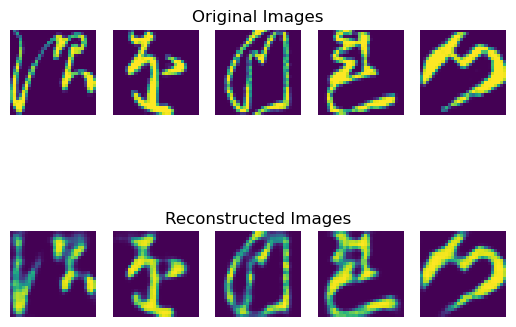

In [36]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


test_images = 5
plt.figure()
f, axarr = plt.subplots(2, test_images) 
axarr[0, 2].set_title("Original Images")
axarr[1, 2].set_title("Reconstructed Images")

model.eval()
with torch.no_grad():
    for i in range(test_images):
        axarr[0][i].axis("off")
        axarr[1][i].axis("off")

        # original images
        x, y = test_data[i][0], test_data[i][1]
        axarr[0, i].imshow(x.permute(1, 2, 0)) # permute tensor to be channels last
        # reconstructed images
        x = x.unsqueeze(0).to(device)
        reconstructed = model(x)
        axarr[1, i].imshow(reconstructed[0].cpu().permute(1, 2, 0))

In [161]:
torch.save(model.state_dict(), "conv_autoencoder.pth")
print("Saved PyTorch Model State to conv_autoencoder.pth")

Saved PyTorch Model State to autoencoder.pth


In [162]:
# we need to recreate the model structure and then load the state dictionary into it
model = ConvAutoencoder().to(device)
model.load_state_dict(torch.load("conv_autoencoder.pth"))

<All keys matched successfully>